# CNN: Aplicando Técnicas de Green Deep Learning

Nesse trabalho escolhemos o dataset do CIFAKE, que contém um total de 20000 imagens, sendo 10000 que realmente fotram fotografadas e 10000 que foram geradas por um computador. O intuito é adaptar uma CNN já existente aplicando Fine Tunning em um modelo já existente, nesse caso o ResNet50, para classificar se essas imagens são genuínas (REAL) ou falsas (FAKE).

### Download do Dataset

Essa etapa só é necessária caso o dataset ainda não esteja na máquina que está rodando. Depois de rodar esse bloco precisa copiar o caminho do diretório de onde está salvo o dataset e adicioná-lo nas variáveis globais (models/globals) em DATASET_PATH.

In [3]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

# print("Path to dataset files:", path)

### Imports

In [5]:
import torch
import torchvision
from torch import nn
from torchvision import models, transforms
import os

from modules import utils
from modules import globals

### Visualizando e adaptando os dados

Afim de explorar o dataset exibimos 9 imagens do CIFAKE e treino e 9 de teste já transformadas para o padrão do ImageNet. Isso é feito porque ResNet50 foi treinado com esse padrão de imagem e para que ele performe bem no nosso dataset é necessário que a entrada possua as mesmas características gerais.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.2535014].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6639653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0007002..2.4285715].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.541961].


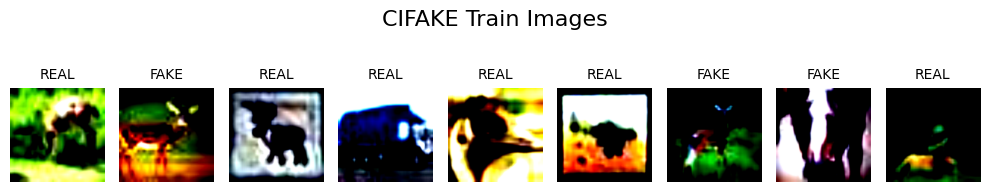

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.3088455].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2885156].

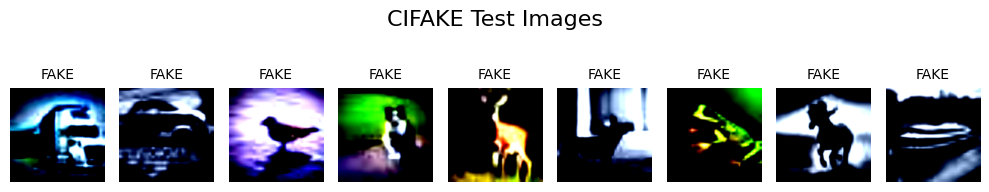

In [ ]:
transform = transforms.Compose([
                                     transforms.Resize(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])
                  ])


# Load the training dataset
train_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'train'),
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=globals.BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

# Load the test dataset
test_dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(globals.DATASET_PATH, 'test'),
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=globals.BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

utils.plot_sample(train_loader, "Train")
utils.plot_sample(test_loader, "Test")

### Fine-Tunning: ResNet50 

Como dito anteriormente será realizado um Fine-tunning a partir da rede pré treinada ResNet50. Esse modelo foi treinado com o dataset do ImageNet e obteve ótimos resultados.

A principal inovação do ResNet é a utilização de conexões residuais. Dessa forma os problemas do "vanishing" ou "exploding" gradient são mitigados e possibilita um aprendizado mais rico, capaz de observar padrões complexos.

Para esse projeto é importante que a rede seja robusta, uma vez que a verficação de deepfakes não é uma tarefa simples. Por isso escolhemos a ResNet com 50 camadas ocultas.

In [17]:
resnet_model = models.resnet50(pretrained=True).to('cpu')
print(resnet_model)

c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\masar\Documents\UFF\IAVerde\ia_verde_cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Identificando e adaptando a camada fully connected (fc)

In [ ]:
print(list(resnet_model.named_children())[-1])

('fc', Linear(in_features=2048, out_features=1000, bias=True))


Precisamos substituir a fc do modelo, uma vez que a mesma possui uma classificação dos dados de entrada em 1000 classes. No caso do nosso problema, serão apenas duas: REAL e FAKE 

In [22]:
in_features = resnet_model.fc.in_features
print(f"Features: {in_features}")

num_classes_cifake = len(globals.CLASS_NAMES)

resnet_model.fc = nn.Linear(in_features, num_classes_cifake).to('cpu')

print(f"Nova camada FC: {resnet_model.fc}")

Features: 2048
Nova camada FC: Linear(in_features=2048, out_features=2, bias=True)
